# Identify Fraudulent Credit Card Users

### It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### The techniques applied here on one such dataset can help classify such fraudulent transactions 


# Importing libraries

In [1]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import display
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as scores
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE


warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

# Declaring variables
metrics_dict = {
    "Accuracy" :[],
    "Precision":[],
    "Recall":[],
    "F1-score":[]
}
row_labels = ["Decision Tree Imbalanced","Naive Bayes Imbalanced","Logistic Regression Imbalanced",
              "Decision Tree with Under-sampling","Naive Bayes with Under-sampling","Logistic Regression with Under-sampling",
              "Decision Tree with Over-sampling","Naive Bayes with Over-sampling","Logistic Regression with Over-sampling"]

feature_imp_classifier = {}

# Importing Credit Card dataset

In [2]:
current_dir = os.getcwd()
path_to_csv = os.path.abspath(os.path.join(current_dir, 'creditcard.csv'))
data = pd.read_csv(path_to_csv)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Quality Check

## Check for null/missing values

In [4]:
# percentage of missing values in each column
round(100 * (data.isnull().sum()/len(data)),2).sort_values(ascending=False)

Class     0.0
V14       0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V15       0.0
Amount    0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Time      0.0
dtype: float64

In [5]:
# percentage of missing values in each row
round(100 * (data.isnull().sum(axis=1)/len(data)),2).sort_values(ascending=False)

284806    0.0
94937     0.0
94931     0.0
94932     0.0
94933     0.0
         ... 
189864    0.0
189863    0.0
189862    0.0
189861    0.0
0         0.0
Length: 284807, dtype: float64

## Note: No missing/null values in the given dataset

## Duplicate check

In [6]:
print(f"Size of dataframe before dropping duplicate rows - {data.shape[0]}")
data.drop_duplicates(subset=None, inplace=True) 
print(f"Size of dataframe after dropping duplicate rows - {data.shape[0]}")

Size of dataframe before dropping duplicate rows - 284807
Size of dataframe after dropping duplicate rows - 283726


# Exploratory Data Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     28

## Note: Different types of variables in this dataset are - float64, Int64

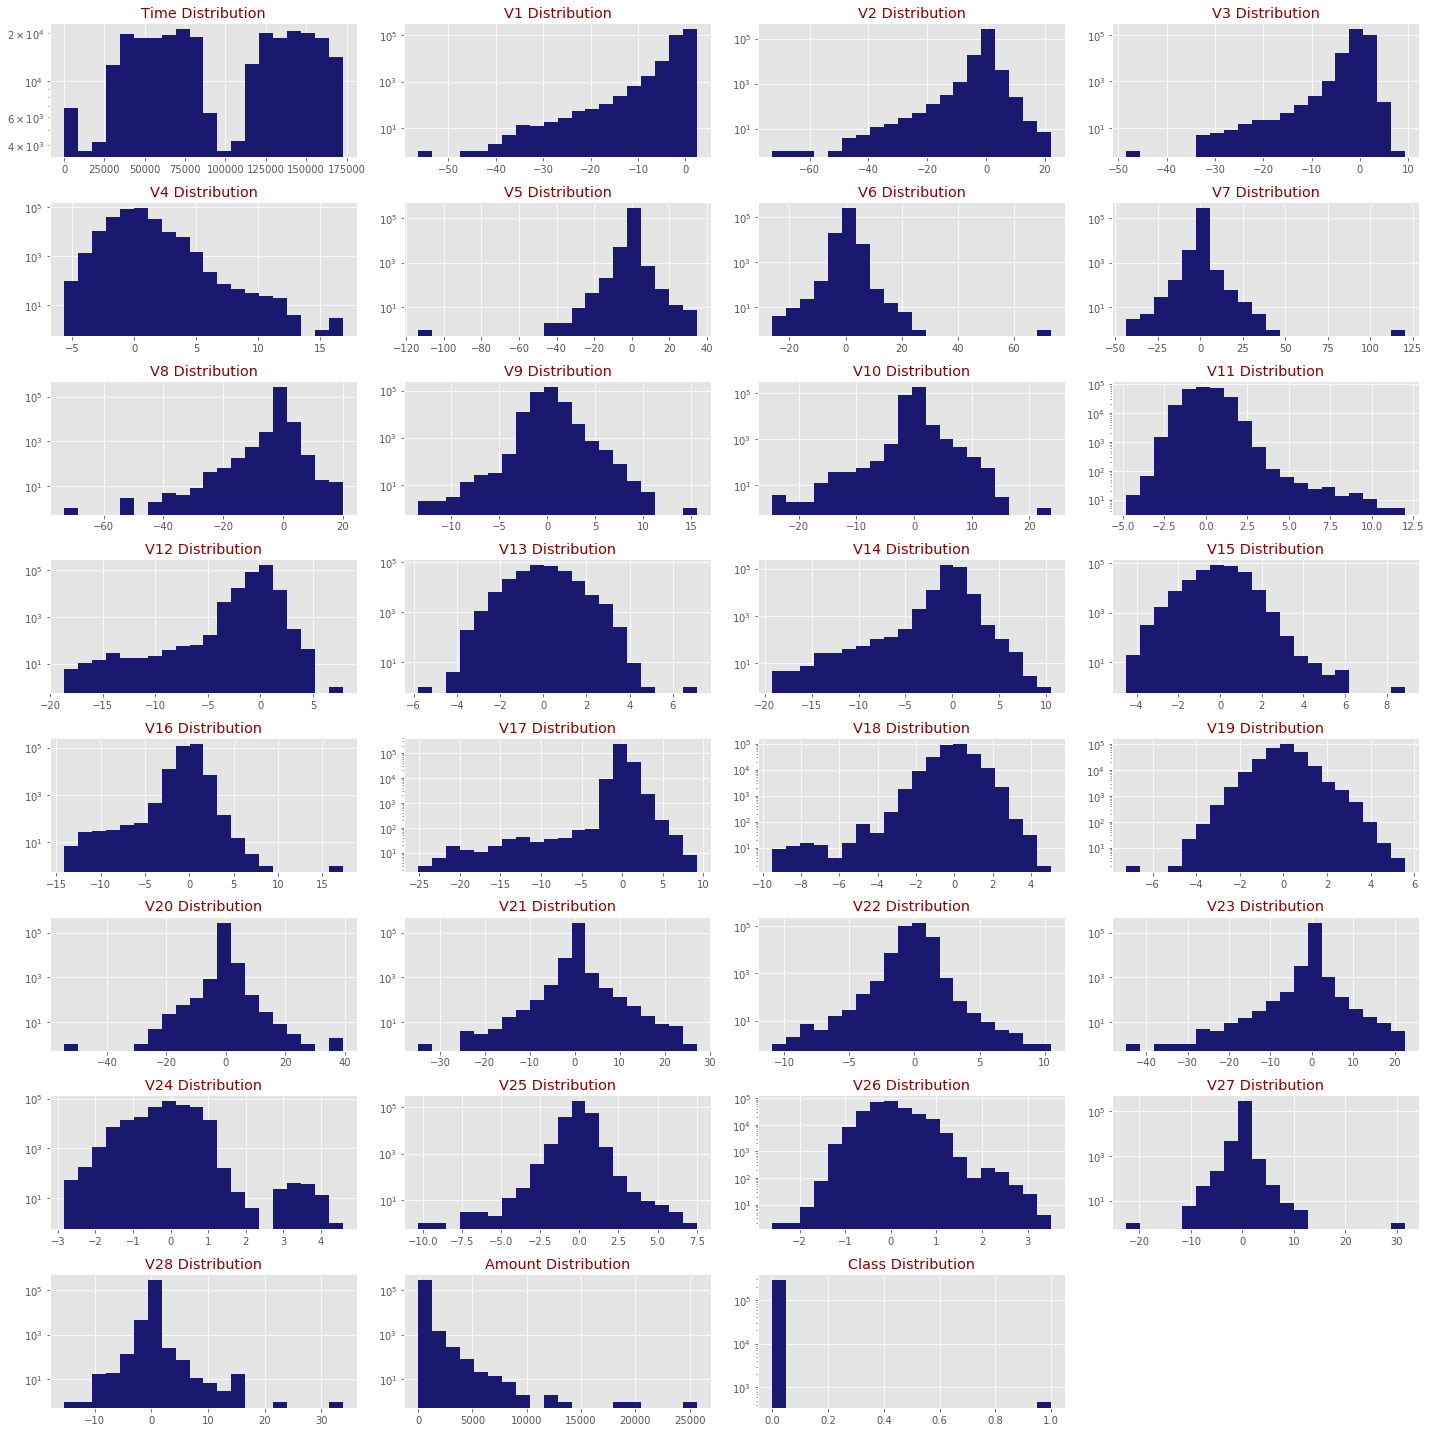

In [8]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(data,data.columns,8,4)

In [9]:
#fraud vs. normal transactions 
counts = data.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100

Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

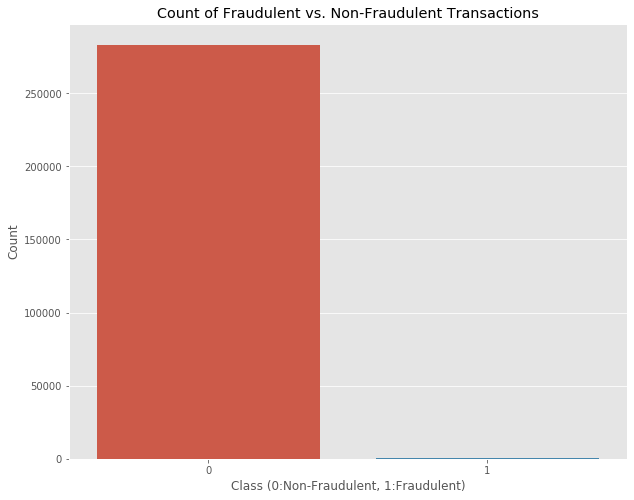

In [10]:
plt.figure(figsize=(10,8))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

### Note: There are 283253 non-fraudulent transactions (99.833%) and 473 fraudulent transactions (0.167%)

### Training our model on the original dataset for creating a predictive model would lead to a lot of errors due to overfitting, misclassifying the fraudulent transactions as legitimate activity due to skewed data.

## Correlation Matrix

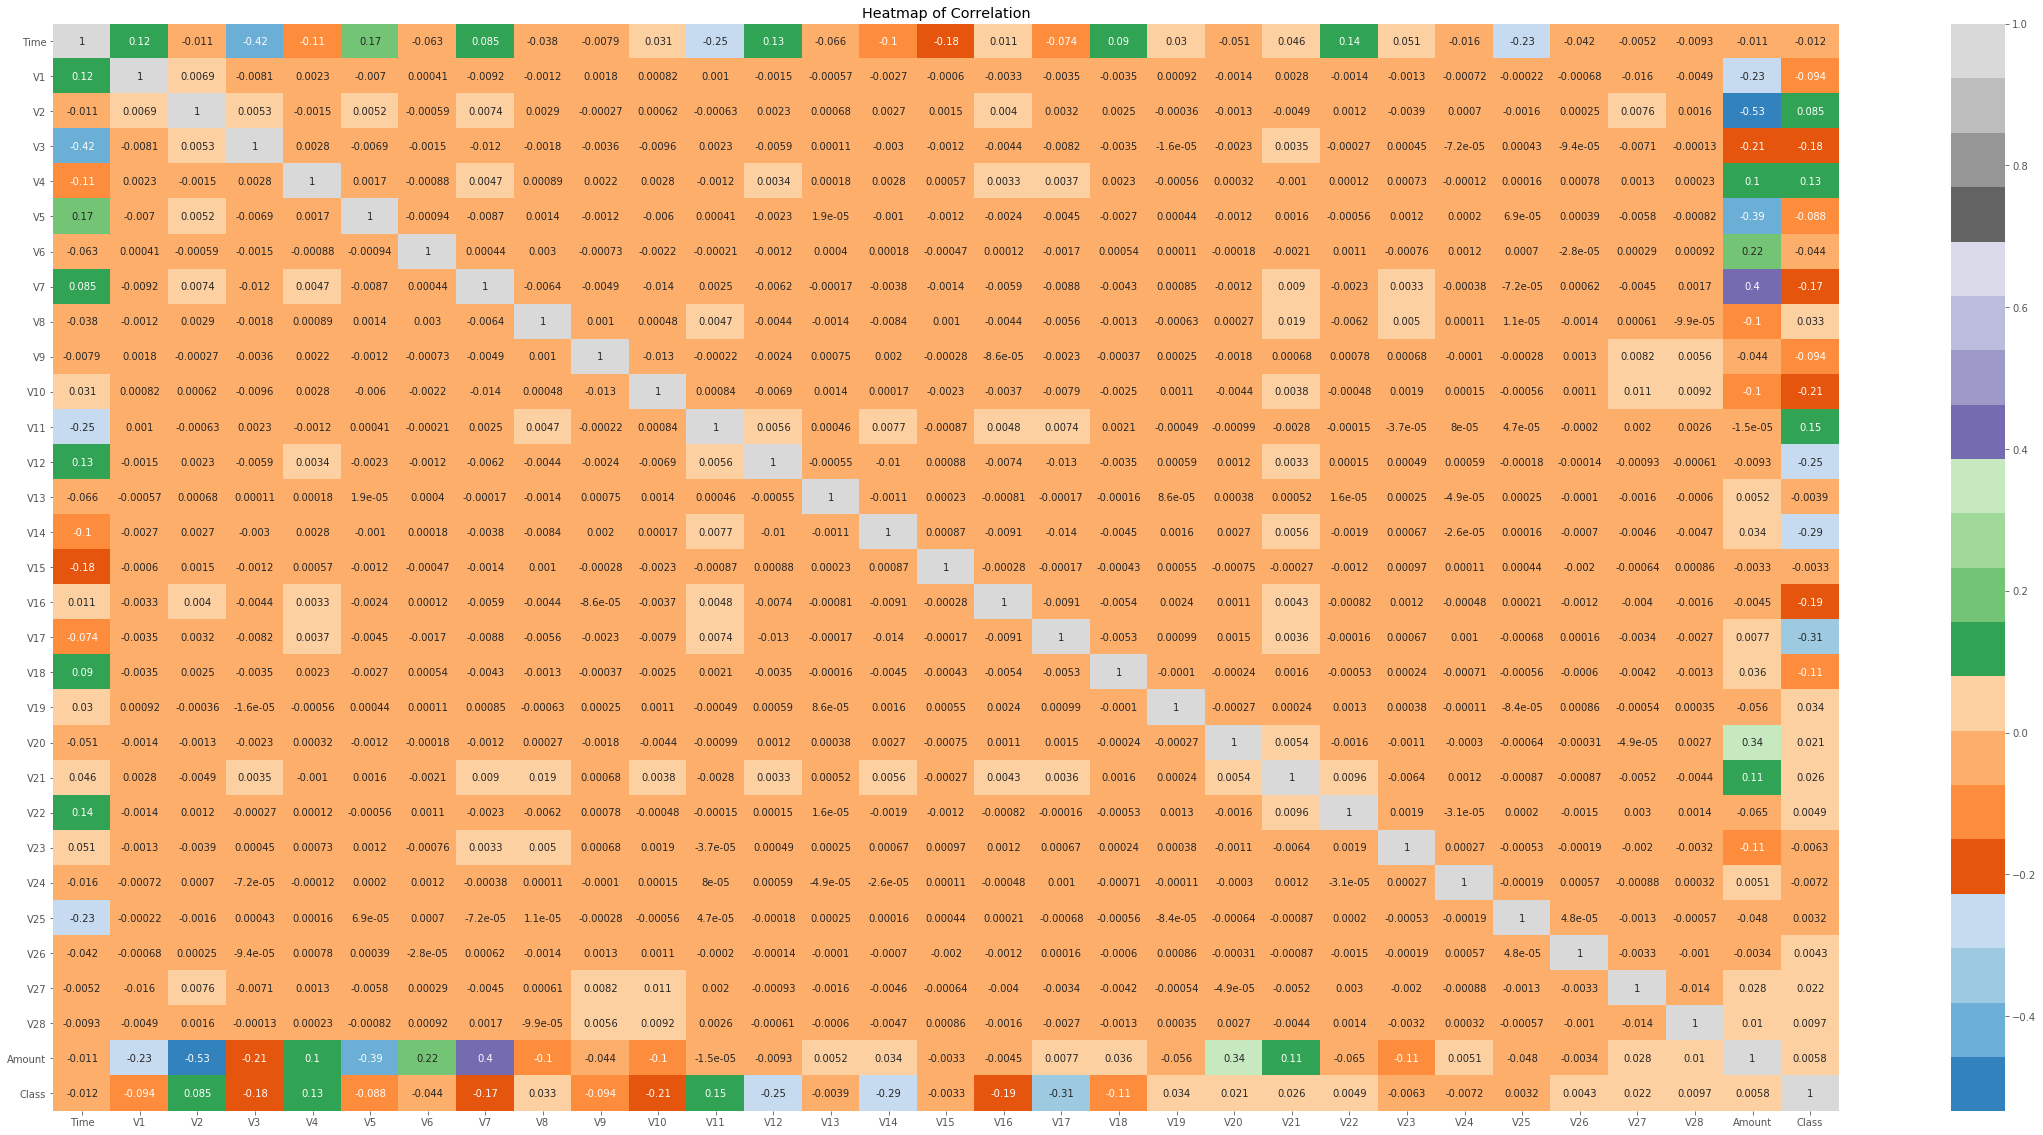

In [11]:
#heatmap
corr = data.corr()
plt.figure(figsize=(40,20))
plt.title('Heatmap of Correlation')
heat = sns.heatmap(data=corr, annot=True, cmap="tab20c")

### Note: The heatmap clearly shows which all variable are multicollinear in nature, and which variable have high collinearity with the target variable.

### The amount and time attributes are not scaled with the rest of the features in the dataset. These can be scaled using standard scaler

In [12]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
amount = data['scaled_amount']
time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'amount', amount)
data.insert(1, 'time', time)

In [13]:
data.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-0.995290,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,-0.995290,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-0.995279,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.411487,-0.995279,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.667362,-0.995267,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Train and test data split before model selection and fitting

In [14]:
X= data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
def plot_confusion_matrix(classifier_type,y_test,y_pred):

    plt.figure(figsize=(5,5))
    ax = plt.subplot()
    plt.title(f"Confusion Matrix with {classifier_type.capitalize()}")
    
    cm_grid = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm_grid, annot=True,fmt=".1f",annot_kws={"size": 20}, ax=ax)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(['Non-fraudulent', 'Frauduent'])   
    ax.yaxis.set_ticklabels(['Non-fraudulent', 'Frauduent'])
    

In [16]:
def build_classifier(classifier_type,x_train,y_train,x_test,y_test):
    if classifier_type.lower() == "decision tree":
        classifier = DecisionTreeClassifier(criterion = 'gini', random_state=0)
        classifier.fit(x_train,y_train.ravel())
        y_pred = classifier.predict(x_test)
        score=scores(y_test,y_pred,average="weighted")
        acc = classifier.score(x_test,y_test)
        
        print(f"We have got accuracy of {round(acc*100,1)} %, precision of {round(score[0]*100,1)} %, recall of {round(score[1]*100,1)} % and F1-score of {round(score[2]*100,1)} %")
        print("and the confusion matrix is drawn below - ")
        plot_confusion_matrix(classifier_type,y_test,y_pred)
        return classifier, acc, score
        
    elif classifier_type.lower() == "naive bayes":
        classifier = GaussianNB()
        classifier.fit(X_train, y_train.ravel())
        y_pred = classifier.predict(x_test)
        score=scores(y_test,y_pred,average="weighted")
        acc = classifier.score(x_test,y_test)
        
        print(f"We have got accuracy of {round(acc*100,1)} %, precision of {round(score[0]*100,1)} %, recall of {round(score[1]*100,1)} % and F1-score of {round(score[2]*100,1)} %")
        print("and the confusion matrix is drawn below - ")
        plot_confusion_matrix(classifier_type,y_test,y_pred)
        return classifier, acc, score
        
    elif classifier_type.lower() == "logistic regression":
        classifier = LogisticRegression(solver='liblinear', random_state=0)
        classifier.fit(X_train, y_train.ravel())
        y_pred = classifier.predict(x_test)
        score=scores(y_test,y_pred,average="weighted")
        acc = classifier.score(x_test,y_test)
        
        print(f"We have got accuracy of {round(acc*100,1)} %, precision of {round(score[0]*100,1)} %, recall of {round(score[1]*100,1)} % and F1-score of {round(score[2]*100,1)} %")
        print("and the confusion matrix is drawn below - ")
        plot_confusion_matrix(classifier_type,y_test,y_pred)
        return classifier, acc, score
    
    pass

We have got accuracy of 99.9 %, precision of 99.9 %, recall of 99.9 % and F1-score of 99.9 %
and the confusion matrix is drawn below - 


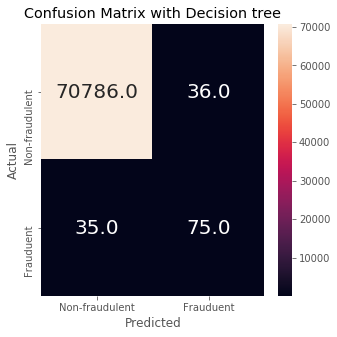

In [17]:
classifier, acc, score = build_classifier("decision tree",X_train,y_train,X_test,y_test)
 
metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

We have got accuracy of 97.7 %, precision of 99.8 %, recall of 97.7 % and F1-score of 98.7 %
and the confusion matrix is drawn below - 


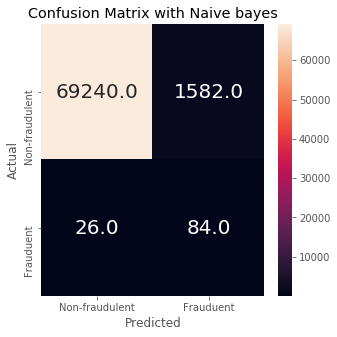

In [18]:
classifier, acc, score = build_classifier("naive bayes",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

We have got accuracy of 99.9 %, precision of 99.9 %, recall of 99.9 % and F1-score of 99.9 %
and the confusion matrix is drawn below - 


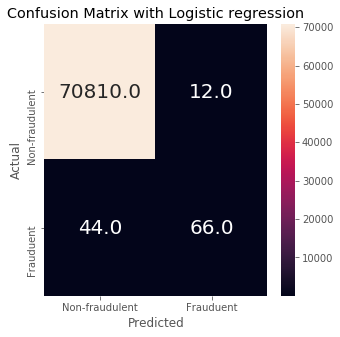

In [19]:
classifier, acc, score = build_classifier("logistic regression",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

### We can see that although the accuracy and other metrics are high but since the dataset is imbalanced, where the number of non-fraudulent cases is much more than the number of fraudulent cases, hence the model is more sensitive to detect the majority class than minority class. To tackle class imbalance, we will use two techniques : under-sampling and over-sampling.

## 1) Using under-sampling and redistribution to target class imbalance
Under-sampling is to randomly select the majority class to balance with the minority class. But the limitation is that data randomly removed from the majority class may be useful to create a robust model.

In [20]:
data = data.sample(frac=1)

fraud_data = data.loc[data['Class']==1]
nfraud_data = data.loc[data['Class']==0][:fraudulent]

normal_distributed_df = pd.concat([fraud_data, nfraud_data])

# Shuffle dataframe rows
ndata = normal_distributed_df.sample(frac=1, random_state=42)

ndata

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42769,1.339174,-0.510681,-10.281784,6.302385,-13.271718,8.925115,-9.975578,-2.832513,-12.703253,6.706846,...,-0.247648,2.479414,0.366933,0.042805,0.478279,0.157771,0.329901,0.163504,-0.485552,1
94218,9.711862,-0.233949,-8.744415,-3.420468,-4.850575,6.606846,-2.800546,0.105512,-3.269801,0.940378,...,-1.818315,0.102913,0.311626,-4.129195,0.034639,-1.133631,0.272265,1.841307,-1.796363,1
86681,-0.287999,-0.274305,1.233861,0.320577,0.430434,0.775543,-0.584518,-1.274444,0.051696,-0.189941,...,-0.131396,-0.273496,-0.819600,0.177385,0.654775,0.152163,0.076307,-0.026539,0.032731,0
214775,-0.296343,0.647801,-0.395582,-0.751792,-1.984666,-0.203459,1.903967,-1.430289,-0.076548,-0.992260,...,-1.027716,1.377515,2.151787,0.189225,0.772943,-0.872443,-0.200612,0.356856,0.032113,1
70589,3.335697,-0.361433,-2.042608,1.573578,-2.372652,-0.572676,-2.097353,-0.174142,-3.039520,-1.634233,...,0.825566,-0.723326,0.501222,-0.696892,-0.600514,0.127547,-0.786072,0.606097,0.171697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219025,-0.243499,0.668355,0.114965,0.766762,-0.494132,0.116772,0.868169,-0.477982,0.438496,0.063073,...,0.062199,-0.284413,-0.706865,0.131405,0.600742,-0.604264,0.262938,0.099145,0.010810,1
154693,-0.292032,0.210669,-2.488363,4.359019,-7.776410,5.364027,-1.823877,-2.445140,-4.964221,1.484890,...,0.792275,1.325672,1.021226,-0.266476,-0.370880,0.365535,0.081372,0.184983,-0.211582,1
210068,0.125156,0.624403,-0.758284,0.239801,-0.261664,0.501864,5.279510,-3.172409,-4.475577,-2.978116,...,0.416513,-1.001425,0.047591,-8.095973,1.099139,0.698266,0.324287,0.296602,0.372156,0
204503,0.866083,0.594894,-3.158990,1.765452,-3.390168,0.987410,-1.509930,-1.280952,-2.719557,0.718325,...,-0.022590,1.120533,1.605085,-0.618637,-0.251283,-0.240528,-0.004327,-0.235477,0.018129,1


### Train and test data split before model selection and fitting

In [21]:
X_n = ndata.iloc[:, ndata.columns != 'Class']
y_n = ndata.iloc[:, ndata.columns == 'Class']

X_train,X_test,y_train,y_test = train_test_split(X_n,y_n, test_size=0.25, random_state=1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Using Decision Tree Classifier

We have got accuracy of 92.4 %, precision of 92.4 %, recall of 92.4 % and F1-score of 92.4 %
and the confusion matrix is drawn below - 


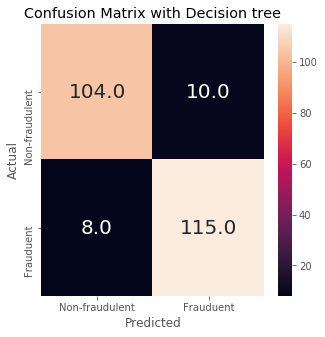

In [22]:
classifier, acc, score = build_classifier("decision tree",X_train,y_train,X_test,y_test)
feature_imp_classifier["decision_tree"] = classifier

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

### Using Naive Bayes Classifier

We have got accuracy of 89.5 %, precision of 89.6 %, recall of 89.5 % and F1-score of 89.5 %
and the confusion matrix is drawn below - 


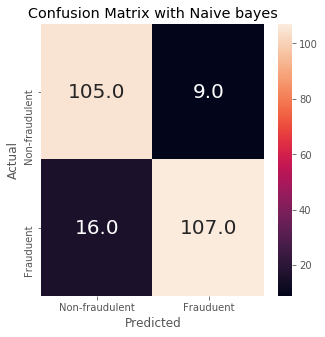

In [23]:
classifier, acc, score = build_classifier("naive bayes",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

### Using Logistic Regression

We have got accuracy of 92.4 %, precision of 92.5 %, recall of 92.4 % and F1-score of 92.4 %
and the confusion matrix is drawn below - 


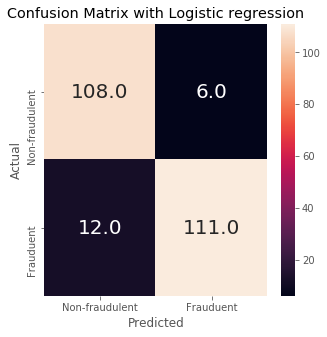

In [24]:
classifier, acc, score = build_classifier("logistic regression",X_train,y_train,X_test,y_test)
feature_imp_classifier["logistic"] = classifier

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

## 2) Using over-sampling to target class imbalance
Over-sampling is to duplicate data in the minority class, but no new information will be added to the model. Alternatively, we can synthesize data from existing ones, referred as Synthetic Minority Over-sampling, or SMOTE for short. SMOTE presented in 2002, works by selecting data that are close or similar in the feature space and drawing a line between data and make new data at a point on the line.

In [25]:
oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X, y)

X_train,X_test,y_train,y_test = train_test_split(X_resample,y_resample, test_size=0.25, random_state=1)

X_train = np.array(X_train)
X_test = np.array(X_test) 
y_train = np.array(y_train)
y_test = np.array(y_test)

### Using Decision Tree Classifier

We have got accuracy of 99.8 %, precision of 99.8 %, recall of 99.8 % and F1-score of 99.8 %
and the confusion matrix is drawn below - 


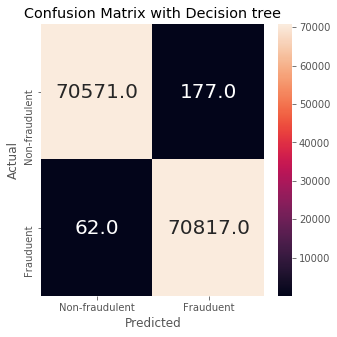

In [26]:
classifier, acc, score = build_classifier("decision tree",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

### Using Naive Bayes Classifier

We have got accuracy of 91.3 %, precision of 91.9 %, recall of 91.3 % and F1-score of 91.2 %
and the confusion matrix is drawn below - 


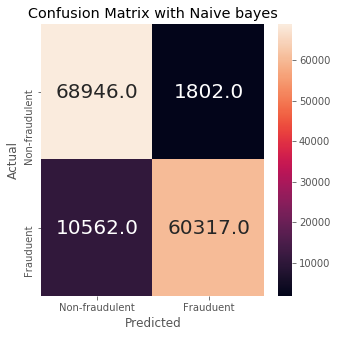

In [27]:
classifier, acc, score = build_classifier("naive bayes",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

### Using Logistic Regression

We have got accuracy of 94.8 %, precision of 94.9 %, recall of 94.8 % and F1-score of 94.8 %
and the confusion matrix is drawn below - 


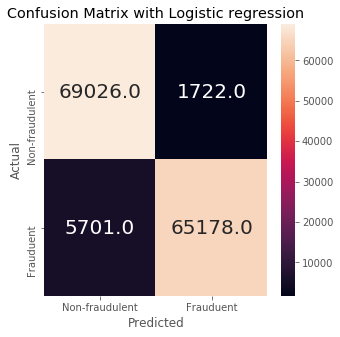

In [28]:
classifier, acc, score = build_classifier("logistic regression",X_train,y_train,X_test,y_test)

metrics_dict["Accuracy"].append(str(round(acc*100,1)) + " %")
metrics_dict["Precision"].append(str(round(score[0]*100,1)) + " %")
metrics_dict["Recall"].append(str(round(score[1]*100,1)) + " %")
metrics_dict["F1-score"].append(str(round(score[2]*100,1)) + " %")

In [29]:
metric_table = pd.DataFrame(data=metrics_dict, index=row_labels)
display(metric_table)

,Accuracy,Precision,Recall,F1-score
Decision Tree Imbalanced,99.9 %,99.9 %,99.9 %,99.9 %
Naive Bayes Imbalanced,97.7 %,99.8 %,97.7 %,98.7 %
Logistic Regression Imbalanced,99.9 %,99.9 %,99.9 %,99.9 %
Decision Tree with Under-sampling,92.4 %,92.4 %,92.4 %,92.4 %
Naive Bayes with Under-sampling,89.5 %,89.6 %,89.5 %,89.5 %
Logistic Regression with Under-sampling,92.4 %,92.5 %,92.4 %,92.4 %
Decision Tree with Over-sampling,99.8 %,99.8 %,99.8 %,99.8 %
Naive Bayes with Over-sampling,91.3 %,91.9 %,91.3 %,91.2 %
Logistic Regression with Over-sampling,94.8 %,94.9 %,94.8 %,94.8 %


## Getting important features from decision tree classifier

amount, Score: 0.010773
time, Score: 0.008079
V1, Score: 0.0
V2, Score: 0.0
V3, Score: 0.007994
V4, Score: 0.0629
V5, Score: 0.004232
V6, Score: 0.008464
V7, Score: 0.0
V8, Score: 0.026312
V9, Score: 0.002821
V10, Score: 0.004918
V11, Score: 0.008965
V12, Score: 0.02797
V13, Score: 0.001624
V14, Score: 0.74925
V15, Score: 0.0
V16, Score: 0.0
V17, Score: 0.02444
V18, Score: 0.0
V19, Score: 0.010992
V20, Score: 0.027081
V21, Score: 0.0
V22, Score: 0.0
V23, Score: 0.0
V24, Score: 0.0
V25, Score: 0.0
V26, Score: 0.008054
V27, Score: 0.00513
V28, Score: 0.0


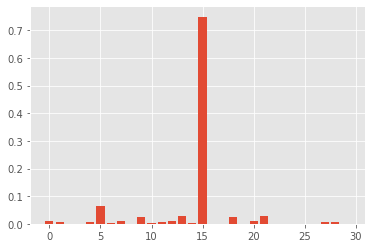

Top 10 features according to Decision tree classifier


[('V14', 0.74925),
 ('V4', 0.0629),
 ('V12', 0.02797),
 ('V20', 0.027081),
 ('V8', 0.026312),
 ('V17', 0.02444),
 ('V19', 0.010992),
 ('amount', 0.010773),
 ('V11', 0.008965),
 ('V6', 0.008464)]

In [30]:
# get importance
importance = feature_imp_classifier["decision_tree"].feature_importances_

# summarize feature importance

features = list(X.columns)
feature_importance = {}
for i,v in enumerate(importance):
    print(f'{features[i]}, Score: {round(v, 6)}')
    feature_importance[features[i]] = round(v, 6)


# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

sorted_tuples = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
print(f"Top 10 features according to Decision tree classifier") 
sorted_tuples[:10]